<a href="https://colab.research.google.com/github/yukilost/googlecolab/blob/main/shoes_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>深層学習を用いたCG・画像処理</strong></h1>

# マルチタスク学習

## 初期設定

### ライブラリのインポート

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import math
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive

### Google Driveのマウント

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


### 使用するデバイスの指定

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


### 各種定数

In [4]:
img_path = "/content/drive/MyDrive/deep/data/"  # 画像が置かれているフォルダ
csv_path = "/content/drive/MyDrive/deep/collect.csv"  # csvファイル
csv_names = ["id", "url", "category", "brand", "price"]  # csvファイルの形式

## データセット

### スクレイピング

Google Colaboratoryでは動かないためローカルで実行する

In [ ]:
# import requests
# from selenium import webdriver
# from bs4 import BeautifulSoup
# import csv
# import time
# import re
# 
# # 画像を保存するディレクトリ
# imgdir = "./data/"
# 
# # 収集したデータの集合
# collected = set()
# 
# # 価格の最大値
# minprice = 10000000
# maxprice = 0
# 
# # カテゴリ、ブランドごとにデータを数える
# categories = {}
# brands = {}
# 
# # csvファイルから収集済みデータを読み込む
# file = open("collect.csv")
# reader = csv.reader(file)
# for row in reader:
#     collected.add(row[1])
#     categories.setdefault(row[2], 0)
#     categories[row[2]] += 1
#     brands.setdefault(row[3], 0)
#     brands[row[3]] += 1
#     if minprice > int(row[4]):
#         minprice = int(row[4])
#     if maxprice < int(row[4]):
#         maxprice = int(row[4])
# file.close()
# 
# # 書き込み用
# file = open("collect.csv", "a", encoding="utf-8", newline="")
# writer = csv.writer(file)
# 
# # 画像のファイル名に使用するid
# id = len(collected)
# 
# cat = ["sneakers", "slip-on", "sandal", "pumps", "boots", "dress-shoes", "ballet-slippers", "loafers", "moccasins", "rain-shoes"]
# start = 1
# end = 21
# 
# driver = webdriver.Chrome()
# soup = BeautifulSoup(driver.page_source, "html.parser")
# 
# for cate in cat:
#     for pagenum in range(start, end):
#         print("{} %".format((pagenum-start)/(end-start)*100))
#         url = "https://zozo.jp/category/shoes/"+cate+"/?pno=" + str(pagenum)
#         driver.get(url)
#         time.sleep(3)
#         soup = BeautifulSoup(driver.page_source, "html.parser")
#         items = soup.find_all("div", class_="catalog-item-container") 
#         for item in items:
#             discountrate = 0
# 
#             content = item.find("img", class_="catalog-img loader")
# 
#             # 稀にcontentがNoneTyepオブジェクトになるため
#             if content:
#                 imgref = content["data-src"]
#             else :
#                 content = item.find("img", class_="catalog-img")
#                 imgref = content["src"]
# 
#             # 収集済みであったらスキップ
#             if imgref in collected:
#                 continue
# 
#             # PR商品であったらスキップ
#             isPR = item.find("div", class_="feed-tag -pr")
#             if isPR != None:
#                 continue
# 
#             img = requests.get(imgref)
# 
#             # カテゴリ
#             # ナイキの「エアマックス（スニーカー）」のようになっているため正規表現によりカテゴリ部分のみを抽出する
#             category = re.match(".*（(.*?)）", content["alt"]).group(1)
# 
#             # 関係ないもの、扱いづらいものはスキップ
#             if category == "その他シューズ" or category == "シューケア用品" or category == "シューズアクセサリー" or category == "インソール/シューズクッション" or category == "シューズ小物/雑貨":
#                 continue
# 
#             # ブランド
#             brand = item.find("div", class_="catalog-h").text
# 
#             # 割引率
#             sale = item.find("span", class_="feed-tag -sale -discountrate")
#             if sale:
#                 discountrate = int(sale.text)
#             else :
#                 sale = item.find("span", class_="feed-tag -timesale -discountrate")
#                 if sale:
#                     discountrate = int(sale.text)
# 
#             # 値段
#             # ￥10,000 のように表示されているため記号を取り除き、割引き前の値段に修正
#             price = int(item.find("div", class_="catalog-price-amount").text[1:].replace(",", ""))
#             price = int(price * 100 / (100-discountrate))
# 
#             # 情報が欠けていたらスキップ
#             if not (imgref and category and brand and price and img):
#                 continue
# 
#             if minprice > price:
#                 minprice = price
#             if maxprice < price:
#                 maxprice = price
#             
#             categories.setdefault(category, 0)
#             categories[category] += 1
#             brands.setdefault(brand, 0)
#             brands[brand] += 1
# 
#             # 書き込み
#             writer.writerow([id, imgref, category, brand, price])
#             imgfile = open(imgdir + str(id) + ".jpg", "wb")
#             imgfile.write(img.content)
#             imgfile.close()
# 
#             # 商品に対して一意なimgrefをキーとして収集済みデータに登録する
#             collected.add(imgref)
# 
#             id += 1
# 
#             # 短時間に集中的にアクセスしないようにする
#             time.sleep(1)
# 
#         print("-"*40)
#         print("page {}".format(pagenum))
#         print("datanum : " + str(len(collected)) + "\n")
# 
#         print("category : " + str(len(categories)) + " categories")
#         for key in categories:
#             print(key + " : " + str(categories[key]))
#         print("\n")
# 
#         print("brand : " + str(len(brands)) + " brands")
#         for key in brands:
#             print(key + " : " + str(brands[key]))
#         print("\n")
# 
#         print("minprice : " + str(minprice))
#         print("maxprice : " + str(maxprice))
#         
#         time.sleep(10)
#     time.sleep(60)
# 
# driver.quit()
#     
# file.close()

### その他ブランドの追加

In [5]:
thresh = 100

df = pd.read_csv(csv_path, names=csv_names)
count = df["brand"].value_counts()

for i in range(len(df)):
  if count[df["brand"][i]] < thresh:
    df["brand"][i] = "その他"

count = df["brand"].value_counts()
print(count)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


その他                     11567
LibertyDoll               667
menue                     662
NIKE                      622
SESTO                     564
HUNTER                    454
AAA+                      436
Minnetonka                426
Odette e Odile            381
AmiAmi                    372
adidas                    350
Vivian                    328
New Balance               304
ORiental TRaffic          298
EMU Australia             270
Shoes in Closet           221
Fabio Rusconi             220
JELLY BEANS               217
EVOL                      202
MAMIAN                    193
RANDA                     193
SVEC                      190
Dedes                     184
KOBE LETTUCE              184
Dr.Martens                180
NOFALL                    179
Reebok                    177
PUMA                      177
FREAK’S STORE             173
SOROTTO                   170
green label relaxing      164
chumchum                  160
CONVERSE                  157
Fin       

### ラベルの対応

In [6]:
label_to_category = np.sort(np.unique(df["category"]))
label_to_brand = np.sort(np.unique(df["brand"]))

data_num = len(df)
category_num = len(label_to_category)
brand_num = len(label_to_brand)

category_to_label = dict()
brand_to_label = dict()

for i in range(category_num):
  category_to_label[label_to_category[i]] = i
for i in range(brand_num):
  brand_to_label[label_to_brand[i]] = i

print(label_to_category)
print(category_to_label)
print(label_to_brand)
print(brand_to_label)

['サンダル' 'スニーカー' 'スリッポン' 'ドレスシューズ' 'バレエシューズ' 'パンプス' 'ブーツ' 'モカシン/デッキシューズ'
 'レインシューズ' 'ローファー']
{'サンダル': 0, 'スニーカー': 1, 'スリッポン': 2, 'ドレスシューズ': 3, 'バレエシューズ': 4, 'パンプス': 5, 'ブーツ': 6, 'モカシン/デッキシューズ': 7, 'レインシューズ': 8, 'ローファー': 9}
['AAA+' 'AmiAmi' 'BIRKENSTOCK' 'CHARLES & KEITH' 'CONVERSE' 'Clarks'
 'Dedes' 'Dr.Martens' 'EMU Australia' 'EVOL' 'Emma Francis'
 'FREAK’S STORE' 'Fabby fabby' 'Fabio Rusconi' 'Fin' 'HARUTA' 'HUNTER'
 'JELLY BEANS' 'Jalan Sriwijaya' 'KOBE LETTUCE' 'LibertyDoll' 'MAMIAN'
 'Minnetonka' 'NIKE' 'NOFALL' 'New Balance' 'ORiental TRaffic'
 'Odette e Odile' 'PUMA' 'RANDA' 'Reebok' 'Repetto' 'SESTO' 'SOROTTO'
 'STYLEBLOCK' 'SVEC' 'Shoes in Closet' 'UGG' 'VANS' 'Vivian' 'YOSUKE'
 'adidas' 'alfredoBANNISTER' 'artemis by DIANA' 'chumchum' 'crocs'
 'green label relaxing' 'menue' 'minia' 'mooimooi' 'その他']
{'AAA+': 0, 'AmiAmi': 1, 'BIRKENSTOCK': 2, 'CHARLES & KEITH': 3, 'CONVERSE': 4, 'Clarks': 5, 'Dedes': 6, 'Dr.Martens': 7, 'EMU Australia': 8, 'EVOL': 9, 'Emma Francis': 10, 'FREAK

### データの分析

data num : 23167

price
max : 209000
min : 550
average : 11039.710968187508
median : 7590.0

category num : 10
バレエシューズ         2400
ブーツ             2400
ドレスシューズ         2400
スリッポン           2399
ローファー           2394
サンダル            2386
レインシューズ         2383
パンプス            2375
スニーカー           2327
モカシン/デッキシューズ    1703
Name: category, dtype: int64

brand num : 51
その他                     11567
LibertyDoll               667
menue                     662
NIKE                      622
SESTO                     564
HUNTER                    454
AAA+                      436
Minnetonka                426
Odette e Odile            381
AmiAmi                    372
adidas                    350
Vivian                    328
New Balance               304
ORiental TRaffic          298
EMU Australia             270
Shoes in Closet           221
Fabio Rusconi             220
JELLY BEANS               217
EVOL                      202
MAMIAN                    193
RANDA                     193
SVEC

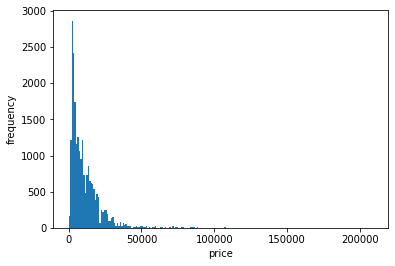

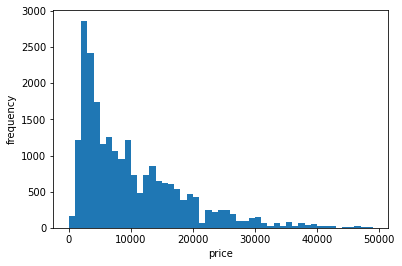

In [7]:
maxprice = np.max(df["price"])
minprice = np.min(df["price"])
aveprice = np.average(df["price"])
medprice = np.median(df["price"])

print("data num : {}\n".format(data_num))

print("price")
print("max : {}".format(maxprice))
print("min : {}".format(minprice))
print("average : {}".format(aveprice))
print("median : {}\n".format(medprice))

print("category num : {}".format(category_num))
print(df["category"].value_counts(), end='\n\n')

print("brand num : {}".format(brand_num))
print(df["brand"].value_counts())

plt.xlabel("price")
plt.ylabel("frequency")
plt.hist(df["price"],bins=np.arange(0, 210000, 1000))
plt.figure()
plt.xlabel("price")
plt.ylabel("frequency")
plt.hist(df["price"],bins=np.arange(0, 50000, 1000))
plt.show()

最高値データの確認

209000
ローファー
その他


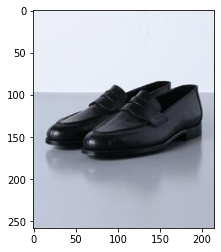

In [ ]:
idx = np.argmax(df["price"])
print(df["price"][idx])
print(df["category"][idx])
print(df["brand"][idx])
image = Image.open(img_path + str(idx) + ".jpg").convert('RGB')
plt.imshow(image)

### データセット作成

In [11]:
class Data(Dataset):
  def __init__(self, img_dir, img_transform):
    super().__init__() 

    self.img_dir = img_dir
    self.img_transform = img_transform

    self.size = data_num
    self.id = df["id"]
    self.price = df["price"]
    self.category = df["category"]
    self.brand = df["brand"]

  def __len__(self):
    return self.size
  
  def __getitem__(self, idx):
    img = self.img_transform(Image.open(self.img_dir + str(self.id[idx]) + '.jpg').convert('RGB'))
    return img, self.price[idx], category_to_label[self.category[idx]], brand_to_label[self.brand[idx]]

img_transform = transforms.Compose([
  transforms.Resize([256, 256]),
  transforms.ToTensor()
])

dataset = Data(img_path, img_transform)

読み込めているか確認

price : 19800
category : スニーカー
brand : NIKE


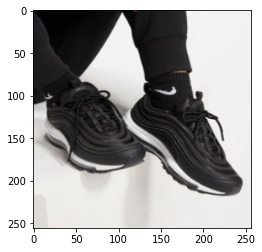

In [12]:
img, price, category_label, brand_label = dataset[0]
plt.imshow(np.asarray(img.numpy().copy().transpose(1, 2, 0)))
print("price : {}".format(price))
print("category : {}".format(label_to_category[category_label]))
print("brand : {}".format(label_to_brand[brand_label]))

### データセット分割

In [13]:
train_size = 20002
test_size = data_num - train_size

print("train size : {}".format(train_size))
print("test size : {}\n".format(test_size))

# データ数に対して割り切れるように設定する
train_batch_size = 73
test_batch_size = 211

print("train batch size : {}".format(train_batch_size))
print("test batch size : {}\n".format(test_batch_size))

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

train size : 20002
test size : 3165

train batch size : 73
test batch size : 211



train_loaderの確認

price : 5316
category : スリッポン
brand : その他



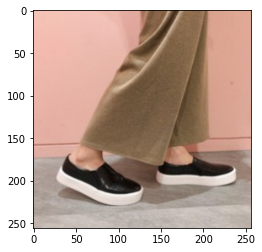

In [14]:
img, price, category_label, brand_label = train_dataset[0]
plt.imshow(np.asarray(img.numpy().copy().transpose(1, 2, 0)))
print("price : {}".format(price))
print("category : {}".format(label_to_category[category_label]))
print("brand : {}\n".format(label_to_brand[brand_label]))

test_loaderの確認

price : 35200
category : ローファー
brand : Jalan Sriwijaya


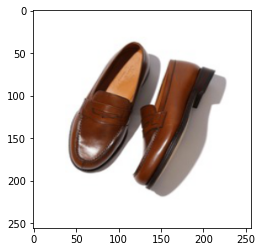

In [15]:
img, price, category_label, brand_label = test_dataset[0]
plt.figure()
plt.imshow(np.asarray(img.numpy().copy().transpose(1, 2, 0)))
print("price : {}".format(price))
print("category : {}".format(label_to_category[category_label]))
print("brand : {}".format(label_to_brand[brand_label]))

## ネットワーク

### ネットワーク定義

In [23]:
class MultiTaskModel(nn.Module):
  def __init__(self, category_size, brand_size):
    super().__init__()
  
    self.cnn = nn.Sequential(
        nn.Conv2d(3, 6, 5), nn.LeakyReLU(), nn.Conv2d(6, 12, 5), nn.LeakyReLU(), nn.MaxPool2d(4, 4),
        nn.Conv2d(12, 24, 5), nn.LeakyReLU(), nn.Conv2d(24, 48, 5), nn.LeakyReLU(), nn.MaxPool2d(3, 3),
        nn.Flatten()
    )
    
    self.price_fc = nn.Sequential(
        nn.Linear(in_features=48*18*18, out_features=512), nn.LeakyReLU(),
        nn.Linear(in_features=512, out_features=1), nn.Identity()
    )
    
    self.category_fc = nn.Sequential(
        nn.Linear(in_features=48*18*18, out_features=512), nn.LeakyReLU(),
        nn.Linear(in_features=512, out_features=category_size)
    )
    
    self.brand_fc = nn.Sequential(
        nn.Linear(in_features=48*18*18, out_features=512), nn.LeakyReLU(),
        nn.Linear(in_features=512, out_features=brand_size)
    )
  
  def forward(self, x):
    x = self.cnn(x)
    price = self.price_fc(x)
    category = self.category_fc(x)
    brand = self.brand_fc(x)
    
    return price, category, brand

## 学習

### 損失関数

不均衡データのため頻度により重み付け

In [20]:
brand_freq = np.zeros(brand_num)

indices = train_dataset.indices
for brand in df["brand"][indices].values:
  brand_freq[brand_to_label[brand]] += 1

print(brand_freq)

weight = torch.Tensor(train_size / brand_freq).to(device)
print(weight)

[ 384.  321.   97.  103.  132.  109.  166.  156.  224.  174.   82.  148.
  109.  190.  119.  117.  402.  182.   99.  161.  567.  171.  373.  536.
  158.  258.  253.  333.  157.  169.  156.   98.  493.  148.   87.  168.
  197.  113.   90.  290.   90.  304.  108.   93.  144.  109.  137.  576.
  109.   97. 9945.]
tensor([ 52.0885,  62.3115, 206.2062, 194.1942, 151.5303, 183.5046, 120.4940,
        128.2179,  89.2946, 114.9540, 243.9268, 135.1487, 183.5046, 105.2737,
        168.0840, 170.9573,  49.7562, 109.9011, 202.0404, 124.2360,  35.2769,
        116.9708,  53.6247,  37.3172, 126.5949,  77.5271,  79.0593,  60.0661,
        127.4013, 118.3550, 128.2179, 204.1020,  40.5720, 135.1487, 229.9081,
        119.0595, 101.5330, 177.0089, 222.2444,  68.9724, 222.2444,  65.7961,
        185.2037, 215.0753, 138.9028, 183.5046, 146.0000,  34.7257, 183.5046,
        206.2062,   2.0113])


In [21]:
price_loss_function = torch.sqrt(nn.MSELoss())
category_loss_function = nn.CrossEntropyLoss()
brand_loss_function = nn.CrossEntropyLoss(weight=weight)

### モデルの学習

In [1]:
model = MultiTaskModel(category_num, brand_num).to(device)
optimizer = torch.optim.AdamW(model.parameters())

epoch_num = 30
# 各lossが約1程度になるように正規化
lambda_price = 0.0001 * 1 # loss10000程度の値が出力されるため
lambda_category = 0.7 * 1
lambda_brand = 0.7 * 1

running_train_losses = []
running_train_price_gaps = []
running_train_category_accurancy = []
running_train_brand_accurancy = []

running_test_losses = []
running_test_price_gaps = []
running_test_category_accurancy = []
running_test_brand_accurancy = []

for epoch in range(epoch_num):
  print("\repoch : {}/{}".format(epoch+1, epoch_num), end='')

  epoch_train_loss = 0
  epoch_train_price_gap = 0
  epoch_train_category_correct = 0
  epoch_train_brand_correct = 0

  epoch_test_loss = 0
  epoch_test_price_gap = 0
  epoch_test_category_correct = 0
  epoch_test_brand_correct = 0

  model.train()
  for image, price, category_label, brand_label in train_loader:
    optimizer.zero_grad()
    
    image = image.to(device)
    price = price.view(train_batch_size, 1).to(device)
    category_label = category_label.to(device)
    brand_label = brand_label.to(device)
  
    pred_price, pred_category, pred_brand = model(image)

    price_loss = price_loss_function(pred_price, price)
    category_loss = category_loss_function(pred_category, category_label)
    brand_loss = brand_loss_function(pred_brand, brand_label)
  
    loss = lambda_price*price_loss
    loss += lambda_category*category_loss
    loss += lambda_brand*brand_loss
  
    loss.backward()
    optimizer.step()

    epoch_train_loss += loss.item() 

    epoch_train_price_loss += price_loss

    pred_category_label = np.argmax(pred_category, 1)
    epoch_train_category_correct += np.sum([pred_category_label == category_label])

    pred_brand_label = np.argmax(pred_brand, 1)
    epoch_train_brand_correct += np.sum([pred_brand_label == brand_label])

  running_train_losses.append(epoch_train_loss/train_size)
  running_train_price_gaps.append(epoch_train_price_gap*train_size/train_batch_size)
  running_train_category_accurancy.append(epoch_train_category_correct*100/train_size)
  running_train_brand_accurancy.append(epoch_train_brand_correct*100/train_size)

  model.eval()
  with torch.no_grad():
    for image, price, category_label, brand_label in test_loader:

      image = image.to(device)
      price = price.view(test_batch_size, 1).to(device)
      category_label = category_label.to(device)
      brand_label = brand_label.to(device)
    
      pred_price, pred_category, pred_brand = model(image)
  
      # 関数内で平均を取っていることに注意
      price_loss = price_loss_function(pred_price, price)
      category_loss = category_loss_function(pred_category, category_label)
      brand_loss = brand_loss_function(pred_brand, brand_label)
    
      loss = lambda_price*price_loss
      loss += lambda_category*category_loss
      loss += lambda_brand*brand_loss

      epoch_test_loss += loss.item()

      epoch_test_price_loss += price_loss

      pred_category_label = np.argmax(pred_category, 1)
      epoch_test_category_correct += np.sum([pred_category_label == category_label])
  
      pred_brand_label = np.argmax(pred_brand, 1)
      epoch_test_brand_correct += np.sum([pred_brand_label == brand_label])
    
  # バッチサイズの大きさによりlossのスケールが異なるため
  running_test_losses.append(epoch_test_loss*train_batch_size/test_batch_size/test_size)
  running_test_price_gaps.append(epoch_test_price_gap*test_size/test_batch_size)
  running_test_category_accurancy.append(epoch_test_category_correct*100/test_size)
  running_test_brand_accurancy.append(epoch_test_brand_correct*100/test_size)

NameError: ignored

## 評価

validationデータを使用せずにパラメータの調整を行っているため参考程度

### 学習曲線

損失

[0.04982222437727465, 0.041310134797963534, 0.03200222706034259, 0.020822610846520328, 0.009774683489047125, 0.0036434400783856027, 0.0017792343055560652, 0.0013414230744299763, 0.0009855932226251268, 0.0013382506539394957]
[0.018501742982186414, 0.016368671616106802, 0.014794166242530184, 0.015298255284627279, 0.019252307569434482, 0.024364955655018113, 0.027736121293681117, 0.030410855942616152, 0.03479030482576922, 0.029358619008960692]


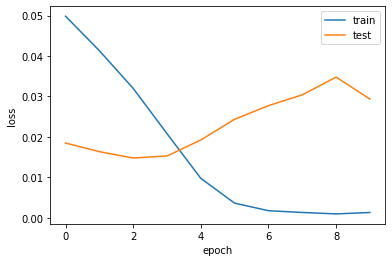

In [ ]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('loss')
p1 = plt.plot(running_train_losses, label='train')
p2 = plt.plot(running_test_losses, label='test')
plt.legend((p1[0], p2[0]), ("train", "test"))
plt.show()

値段のずれ

In [ ]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('price error')
p1 = plt.plot(running_train_price_gaps, label='train')
p2 = plt.plot(running_test_price_gaps, label='test')
plt.legend((p1[0], p2[0]), ("train", "test"))
plt.show()

micro平均

In [ ]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('accurancy')
p1 = plt.plot(running_train_category_accurancy, label='train')
p2 = plt.plot(running_test_category_accurancy, label='test')
plt.legend((p1[0], p2[0]), ("train", "test"))
plt.show()

In [ ]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('accurancy')
p1 = plt.plot(running_train_brand_accurancy, label='train')
p2 = plt.plot(running_test_brand_accurancy, label='test')
plt.legend((p1[0], p2[0]), ("train", "test"))
plt.show()

### 具体例の確認

predicted price : 1824.4612216949463, true price : 12100
predicted category : スニーカー, true category : スリッポン
predicted brand : その他, true brand : その他


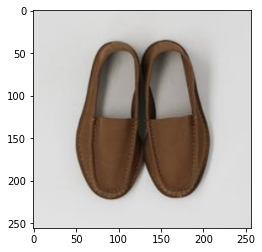

In [ ]:
index = random.randint(0, test_size-1)
image, price, category_label, brand_label = test_dataset[index]
image = image.reshape(1, 3, 256, 256).to(device)

model.eval()
with torch.no_grad():
    pred_price, pred_category, pred_brand = model(image)

image = image.reshape(3, 256, 256)
image = image.cpu()
pred_category = pred_category.cpu()
pred_brand = pred_brand.cpu()

pred_category_label = np.argmax(pred_category.numpy().copy())
pred_brand_label = np.argmax(pred_brand.numpy().copy())

plt.imshow(np.asarray(image.numpy().copy().transpose(1, 2, 0)))

print("predicted price : {}, true price : {}".format(pred_price.item()*price_div, price))
print("predicted category : {}, true category : {}".format(label_to_category[pred_category_label], label_to_category[category_label]))
print("predicted brand : {}, true brand : {}".format(label_to_brand[pred_brand_label], label_to_brand[brand_label]))

## 保存

### パラメータの保存

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/deep/params/multi.pth')